In [2]:
from __future__ import division, print_function

## Evaluate deep model for sequence editing from Keras

### Obtain data and keras model
We will load a keras model and compute importance scores

#### Download the keras model
Download a model with 2 strided convolutional layers and 2 dense layers, similar to the one in the paper.

Tweaking

### Load the keras model
A user warning about compilation is generated because this model was converted from a keras 1.2 model and was thus never compiled for training.

In [88]:
import keras
saved_model_file = "/home/ubuntu/CRISPR-BE-RNA-editing/model_outputs/CBE-19MAR/overall_model.h5"
keras_model = keras.models.load_model(saved_model_file)
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 94, 1024)          41984     
_________________________________________________________________
downsample1 (MaxPooling1D)   (None, 94, 1024)          0         
_________________________________________________________________
conv2 (Conv1D)               (None, 90, 64)            327744    
_________________________________________________________________
downsample2 (MaxPooling1D)   (None, 90, 64)            0         
_________________________________________________________________
dropout1 (Dropout)           (None, 90, 64)            0         
_________________________________________________________________
conv3 (Conv1D)               (None, 86, 64)            20544     
_________________________________________________________________
conv4 (Conv1D)               (None, 84, 64)            12352     
__________

### Load the data

In [89]:
import gzip
import glob
import numpy as np
import random
import pandas

seqlen = 101
edit_pos = 50
#data_path = "/home/ubuntu/CRISPR-ABE-RNA-DATA/fastas/ABE-forDeepLift/156B-mid-sampled.fasta.gz"
data_path = "/home/ubuntu/CRISPR-CBE-RNA-DATA/fastas/CBE-forDeepLift/89B-mid-sampled.fasta.gz"
def read_fasta(f):
    def gen():
        for l in gzip.open(f, "r"):
            if l.startswith(b'>'):
                library, location, strand, rate, cov, anno, gene = l.split(b'_')
                name = l.strip()[1:]
            else:
                yield l.strip().decode().lower(), float(rate), name
    stack = pandas.DataFrame.from_records([v for v in gen()], columns="sequence rate name".split())
    print(f, stack.shape[0])
    return stack


seq_df = read_fasta(data_path)

('/home/ubuntu/CRISPR-CBE-RNA-DATA/fastas/CBE-forDeepLift/89B-mid-sampled.fasta.gz', 1000)


In [90]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),5), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        
        # Hard-coded edit-specific channel
        if(i == edit_pos):
            char_idx = 4 # this corresponds to the edit - specific channel
        elif (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in seq_df.sequence])

In [91]:
onehot_data.shape

(1000, 101, 5)

## Prepare the deeplift models

### Model conversion
Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT-RevealCancel, gradients and guided backprop

In [92]:
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc

#revealcancel_model = kc.convert_model_from_saved_files(
#                            h5_file=saved_model_file,
#                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
#grad_model = kc.convert_model_from_saved_files(
#                            h5_file=saved_model_file,
#                            nonlinear_mxts_mode=NonlinearMxtsMode.Gradient)
#guided_backprop_model = kc.convert_model_from_saved_files(
#                            h5_file=saved_model_file,
#                            nonlinear_mxts_mode=NonlinearMxtsMode.GuidedBackprop)
rescale_conv_revealcancel_fc = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT_GenomicsDefault)


nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 0 the preceding linear layer is preact_0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 2 the preceding linear layer is preact_2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 5 the preceding linear layer is preact_5 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 6 the preceding linear layer is preact_6 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
He

In [93]:
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

#revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-1)
genomics_func = rescale_conv_revealcancel_fc.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-1)

### Call scoring functions on the data

In [94]:
scores = np.array(genomics_func( # revealcancel_func
            task_idx=0,
            input_data_list=[onehot_data],
            input_references_list=[np.zeros_like(onehot_data)],
            batch_size=1000,
            progress_update=None))


In [95]:
# Write out to file
file_handle_out = open("CBE-outfile.tsv", "w")

# i defines which sequence is being examined
for i in range(0,onehot_data.shape[0]): 
    scores_seq = scores[i,]
    for pos_in_seq in range(0,onehot_data.shape[1]): # onehot_data.shape[1]
        char = seq_df.sequence[i][pos_in_seq].decode()
        
        if(pos_in_seq == edit_pos):
            char_idx == 4
            char = "e"
        elif (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        
        seq_name = seq_df.name[i]
        score = round(scores_seq[pos_in_seq,char_idx],4)
        if((score < 1e-05) and (score > -1e-05)):
                score = 0
        file_handle_out.write(("\t".join([seq_name, char, str(pos_in_seq + 1), str(score)])+"\n"))
        
file_handle_out.close()

Preceding 10 bases: agagaaggc
Preceding 10 bases: cgagtcctcg
Edit rate: 0.6833
Predicted editing rate: [0.03541166]


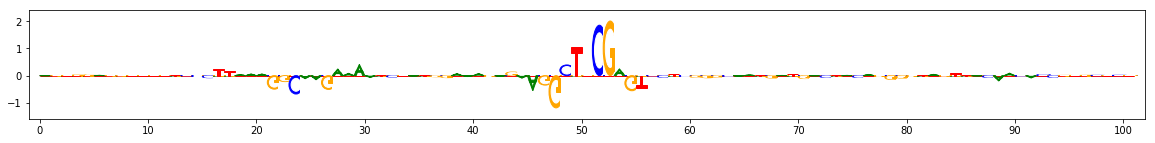

In [83]:
%matplotlib inline
from deeplift.visualization import viz_sequence

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

idx_view = 16
print("Preceding 10 bases: " + weighted_arrays[0].sequence[idx_view][40:49])
print("Preceding 10 bases: " + weighted_arrays[0].sequence[idx_view][51:61])
print("Edit rate: " + str(weighted_arrays[0].rate[idx_view]))
print("Predicted editing rate: " + str(inv_logit(predictions[idx_view])))

scores_for_idx = scores2[idx_view]

viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10)